# Linear Regression
### EK 10/26

Using all features to predict attention with linear regression.

### Imports

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler


### Read in data

In [22]:
games = pd.read_csv("/Users/elisabethkollrack/Thesis/EK-thesis/game_attention.csv")
# drop when attention is 0
games = games[games['attention'] > 0]
# adjust attention
# take log of attention
games['log_attention'] = np.log10(games['attention'])


In [23]:
# correlation between log_attention and attention
corr = games[['attention', 'log_attention']].corr().iloc[0,1]
print(f"Correlation between attention and log_attention: {corr}")

Correlation between attention and log_attention: 0.7359205367898948


In [24]:
games

,date,game_id,season,week,weekday,gametime,home_team,away_team,home_win_pct,away_win_pct,num_lead_changes,total_score,score_differential,overtime,attention,log_attention
0,2013-09-05,2013_01_BAL_DEN,2013,1,Thursday,20:30,DEN,BAL,0.000000,0.000000,1,76.0,22.0,0,1906,3.280123
1,2013-09-08,2013_01_NE_BUF,2013,1,Sunday,13:00,BUF,NE,0.000000,0.000000,2,44.0,2.0,0,376,2.575188
2,2013-09-08,2013_01_SEA_CAR,2013,1,Sunday,13:00,CAR,SEA,0.000000,0.000000,2,19.0,5.0,0,482,2.683047
3,2013-09-08,2013_01_CIN_CHI,2013,1,Sunday,13:00,CHI,CIN,0.000000,0.000000,2,45.0,3.0,0,349,2.542825
4,2013-09-08,2013_01_MIA_CLE,2013,1,Sunday,13:00,CLE,MIA,0.000000,0.000000,2,33.0,13.0,0,372,2.570543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,2017-12-31,2017_17_OAK_LAC,2017,17,Sunday,16:25,LAC,OAK,0.533333,0.400000,2,40.0,20.0,0,480,2.681241
1276,2017-12-31,2017_17_BUF_MIA,2017,17,Sunday,16:25,MIA,BUF,0.400000,0.533333,0,38.0,6.0,0,428,2.631444
1277,2017-12-31,2017_17_ARI_SEA,2017,17,Sunday,16:25,SEA,ARI,0.600000,0.466667,2,50.0,2.0,0,61,1.785330
1278,2017-12-31,2017_17_NO_TB,2017,17,Sunday,16:25,TB,NO,0.266667,0.733333,4,55.0,7.0,0,463,2.665581


### Adjust game time to minutes and date to datetime format

In [25]:

# convert date to datetime
games['date'] = pd.to_datetime(games['date'])

# convert gametime from military string to morning, afternoon, evening, and night
def categorize_time(time_str):
    hour = int(time_str.split(':')[0])
    
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

# Assuming your column is named 'gametime'
games['gametime'] = games['gametime'].apply(categorize_time)
games



,date,game_id,season,week,weekday,gametime,home_team,away_team,home_win_pct,away_win_pct,num_lead_changes,total_score,score_differential,overtime,attention,log_attention
0,2013-09-05,2013_01_BAL_DEN,2013,1,Thursday,evening,DEN,BAL,0.000000,0.000000,1,76.0,22.0,0,1906,3.280123
1,2013-09-08,2013_01_NE_BUF,2013,1,Sunday,afternoon,BUF,NE,0.000000,0.000000,2,44.0,2.0,0,376,2.575188
2,2013-09-08,2013_01_SEA_CAR,2013,1,Sunday,afternoon,CAR,SEA,0.000000,0.000000,2,19.0,5.0,0,482,2.683047
3,2013-09-08,2013_01_CIN_CHI,2013,1,Sunday,afternoon,CHI,CIN,0.000000,0.000000,2,45.0,3.0,0,349,2.542825
4,2013-09-08,2013_01_MIA_CLE,2013,1,Sunday,afternoon,CLE,MIA,0.000000,0.000000,2,33.0,13.0,0,372,2.570543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,2017-12-31,2017_17_OAK_LAC,2017,17,Sunday,afternoon,LAC,OAK,0.533333,0.400000,2,40.0,20.0,0,480,2.681241
1276,2017-12-31,2017_17_BUF_MIA,2017,17,Sunday,afternoon,MIA,BUF,0.400000,0.533333,0,38.0,6.0,0,428,2.631444
1277,2017-12-31,2017_17_ARI_SEA,2017,17,Sunday,afternoon,SEA,ARI,0.600000,0.466667,2,50.0,2.0,0,61,1.785330
1278,2017-12-31,2017_17_NO_TB,2017,17,Sunday,afternoon,TB,NO,0.266667,0.733333,4,55.0,7.0,0,463,2.665581


### Encode categorical features

In [26]:
categorical_cols = ['weekday', 'home_team', 'away_team', 'gametime']
games_encoded = pd.get_dummies(games, columns=categorical_cols, drop_first=True)


### Visualize numeric features

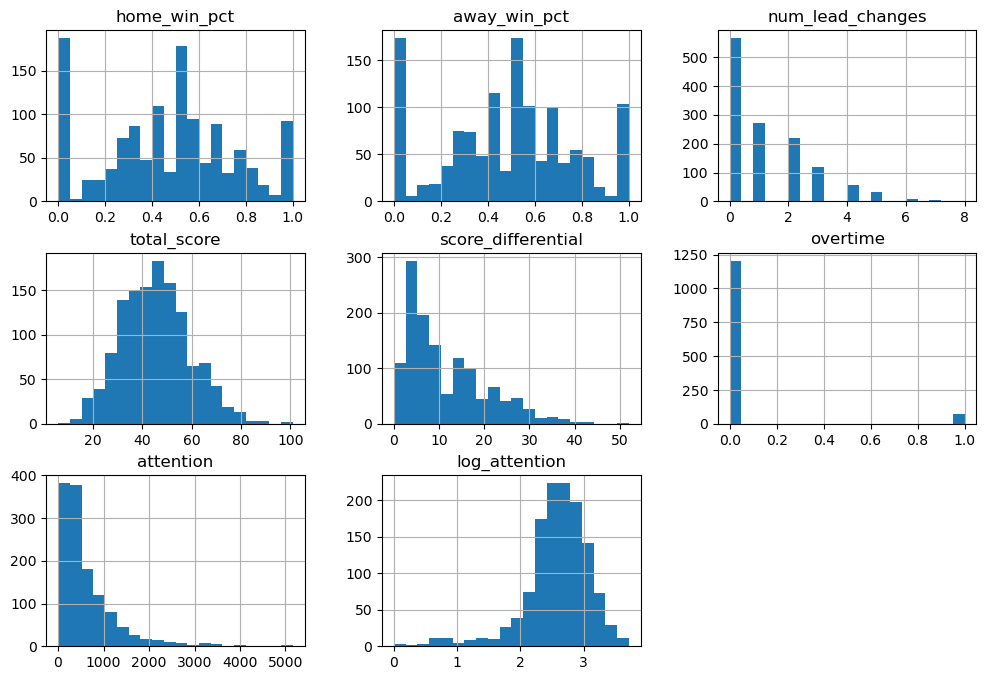

In [27]:

numeric_cols = ['home_win_pct','away_win_pct','num_lead_changes','total_score','score_differential','overtime','attention', 'log_attention']
games[numeric_cols].hist(figsize=(12,8), bins=20)
plt.show()

- Attention is right skewed, so I took the log of it and it looks more normal
- Score differential and # of lead changes are also right skewed

### Correlation Analysis

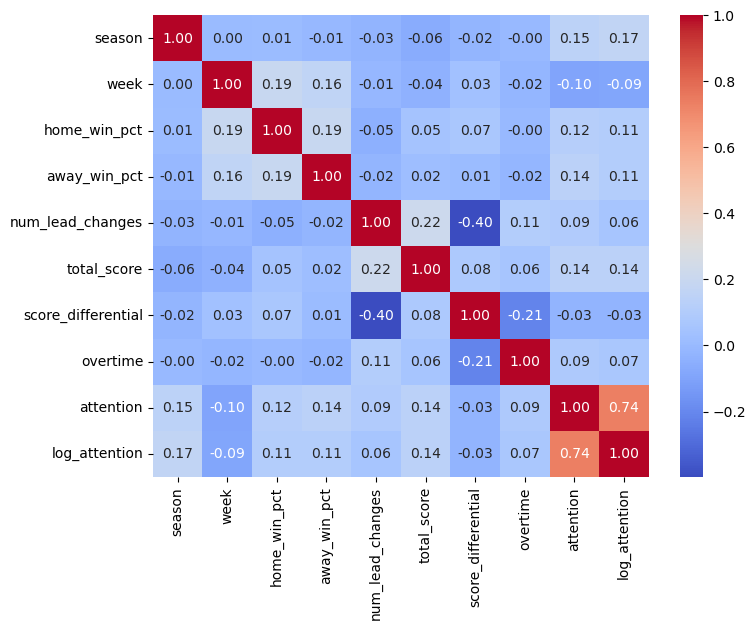

In [28]:
plt.figure(figsize=(8,6))
sns.heatmap(games_encoded.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


- Highest correlation (-0.40) between number of lead changes and score differential and attention and log attention (expected)

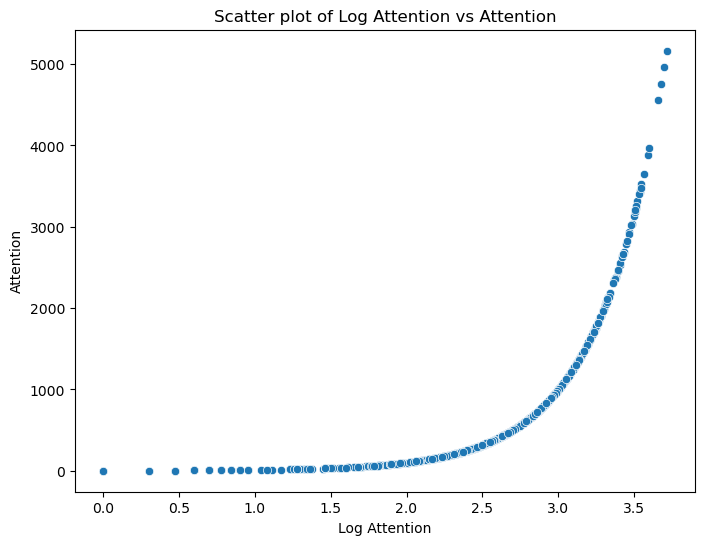

In [44]:
# scatter plot for correlation for log_attention and attention
plt.figure(figsize=(8,6))
sns.scatterplot(x='log_attention', y='attention', data=games)
plt.title('Scatter plot of Log Attention vs Attention')
plt.xlabel('Log Attention')
plt.ylabel('Attention')
plt.show()

### Attention by Weekday

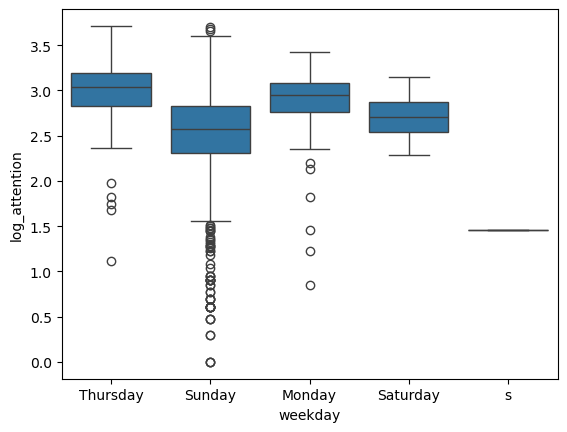

In [30]:
sns.boxplot(x='weekday', y='log_attention', data=games)
plt.show()


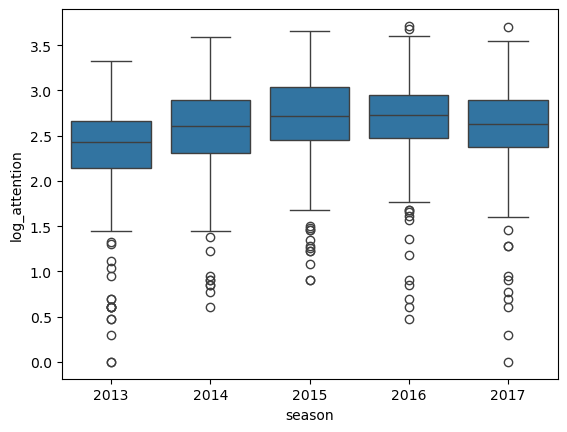

In [31]:
sns.boxplot(x='season', y='log_attention', data=games)
plt.show()

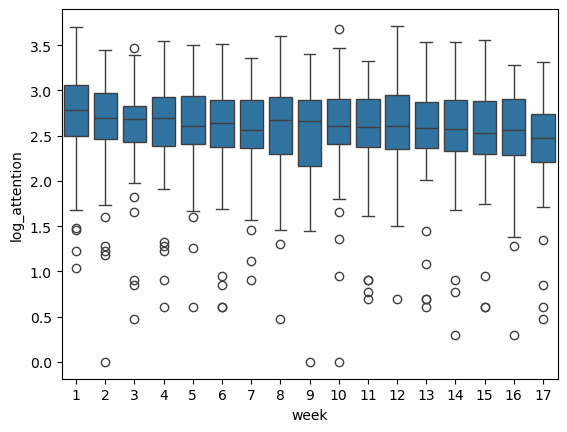

In [32]:
sns.boxplot(x='week', y='log_attention', data=games)
plt.show()

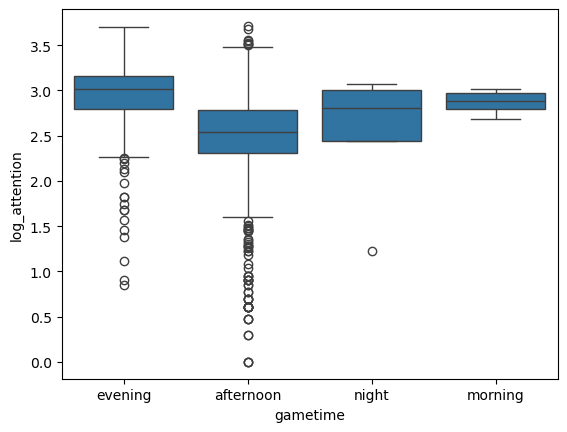

In [33]:
sns.boxplot(x='gametime', y='log_attention', data=games)
plt.show()

### Check for multicollinearity

In [34]:
X = games_encoded.select_dtypes(include='number').drop(columns=['attention', 'log_attention'])
vif = pd.DataFrame()
vif['feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values(by='VIF', ascending=False)


,feature,VIF
0,season,19.377421
5,total_score,12.832880
1,week,4.534696
3,away_win_pct,4.053689
2,home_win_pct,3.928613
6,score_differential,3.375869
4,num_lead_changes,2.197209
7,overtime,1.120219


- Need to think about multicollinearity with season, gametime, and total_score.

## Linear Regression

In [35]:
games_encoded.columns

Index(['date', 'game_id', 'season', 'week', 'home_win_pct', 'away_win_pct',
       'num_lead_changes', 'total_score', 'score_differential', 'overtime',
       'attention', 'log_attention', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_s', 'home_team_ATL', 'home_team_BAL',
       'home_team_BUF', 'home_team_CAR', 'home_team_CHI', 'home_team_CIN',
       'home_team_CLE', 'home_team_DAL', 'home_team_DEN', 'home_team_DET',
       'home_team_GB', 'home_team_HOU', 'home_team_IND', 'home_team_JAX',
       'home_team_KC', 'home_team_LA', 'home_team_LAC', 'home_team_MIA',
       'home_team_MIN', 'home_team_NE', 'home_team_NO', 'home_team_NYG',
       'home_team_NYJ', 'home_team_OAK', 'home_team_PHI', 'home_team_PIT',
       'home_team_SD', 'home_team_SEA', 'home_team_SF', 'home_team_STL',
       'home_team_TB', 'home_team_TEN', 'home_team_WAS', 'away_team_ATL',
       'away_team_BAL', 'away_team_BUF', 'away_team_CAR', 'away_team_CHI',
       'away_team_CIN', 'away_te

In [36]:
# Drop irrelevant columns
X = games_encoded.drop(columns=['attention','log_attention', 'game_id', 'date'])  # only numeric/coded features
y = games_encoded['log_attention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)

RMSE: 0.26408365172144455
R^2: 0.7233634497350179


In [37]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaled linear regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance After Scaling:")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

importance = np.abs(lr.coef_)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_,
    'Absolute Importance': importance
}).sort_values(by='Absolute Importance', ascending=False)

print("Top Features by Importance (after scaling):")
print(feature_importance.head(20))


Model Performance After Scaling:
RMSE: 0.2641
R^2: 0.7234
Top Features by Importance (after scaling):
          Feature  Coefficient  Absolute Importance
19  home_team_DAL     0.375126             0.375126
22   home_team_GB     0.363968             0.363968
39  home_team_SEA     0.355589             0.355589
31   home_team_NE     0.325851             0.325851
15  home_team_CAR     0.324357             0.324357
20  home_team_DEN     0.323212             0.323212
52  away_team_DAL     0.319636             0.319636
12  home_team_ATL     0.319070             0.319070
16  home_team_CHI     0.312879             0.312879
32   home_team_NO     0.309012             0.309012
18  home_team_CLE     0.308740             0.308740
55   away_team_GB     0.301045             0.301045
33  home_team_NYG     0.300702             0.300702
14  home_team_BUF     0.293201             0.293201
40   home_team_SF     0.292305             0.292305
21  home_team_DET     0.291420             0.291420
29  home_team_

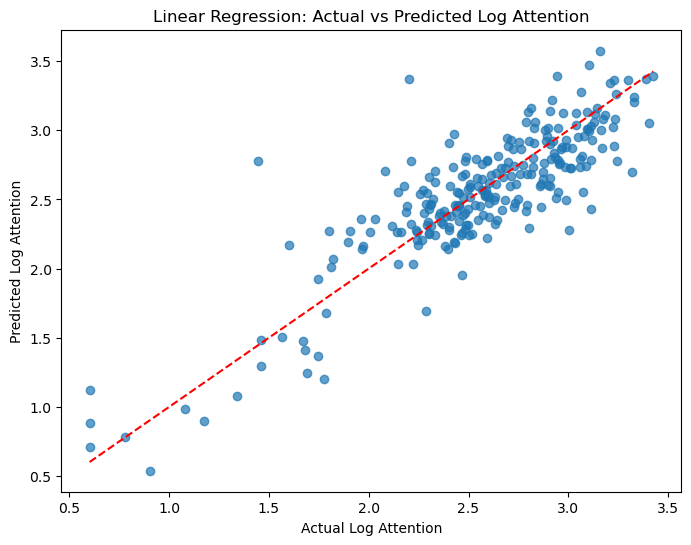

In [38]:
# plot linear regression model
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Log Attention")
plt.ylabel("Predicted Log Attention")
plt.title("Linear Regression: Actual vs Predicted Log Attention")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


In [39]:
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_})
coefficients.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
19,home_team_DAL,3.751257e-01
22,home_team_GB,3.639680e-01
39,home_team_SEA,3.555887e-01
31,home_team_NE,3.258512e-01
15,home_team_CAR,3.243569e-01
...,...,...
11,weekday_s,2.775558e-16
8,weekday_Saturday,-1.131233e-03
6,score_differential,-3.156459e-03
9,weekday_Sunday,-2.989867e-02


- More popular teams with higher coefficients... makes sense (I think?)

### Residual analysis

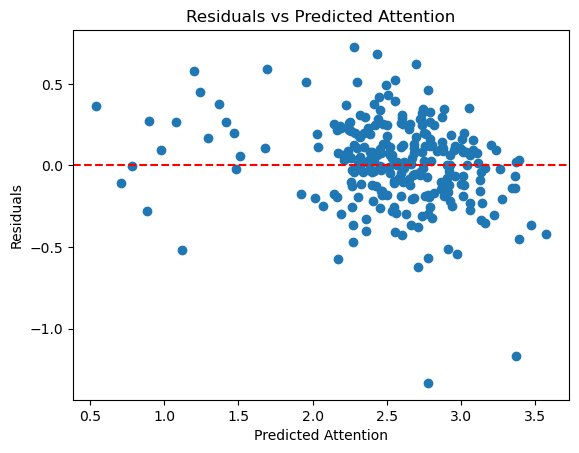

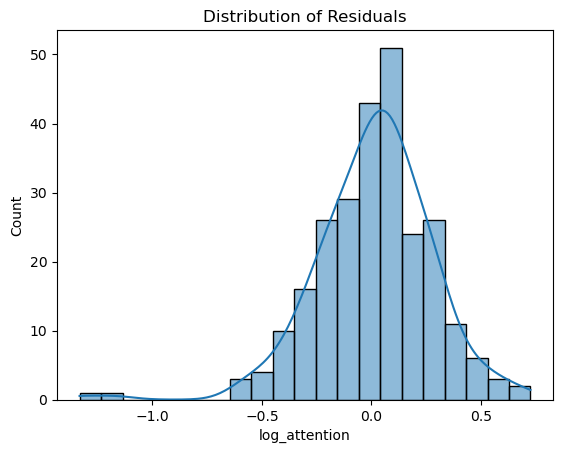

In [40]:
# Residual analysis 
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Attention")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Attention")
plt.show()
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()


### LR with Interaction Terms

In [41]:
# interaction terms
X['home_away_win_interaction'] = X['home_win_pct'] * X['away_win_pct']
X['lead_diff_interaction'] = X['num_lead_changes'] * X['score_differential']
X['total_score_leads_interaction'] = X['total_score'] * X['num_lead_changes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("With Selective Interaction Terms:")
print("RMSE:", rmse)
print("R^2:", r2)


With Selective Interaction Terms:
RMSE: 0.26475173885002495
R^2: 0.7219619915557367
